<a href="https://colab.research.google.com/github/TAUforPython/machinelearning/blob/main/example%20AE%20and%20Transformer%20attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Autoencoder example


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - loss: 0.0904 - val_loss: 0.0295
Epoch 2/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - loss: 0.0263 - val_loss: 0.0183
Epoch 3/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.0173 - val_loss: 0.0137
Epoch 4/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 0.0133 - val_loss: 0.0113
Epoch 5/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.0114 - val_loss: 0.0101
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


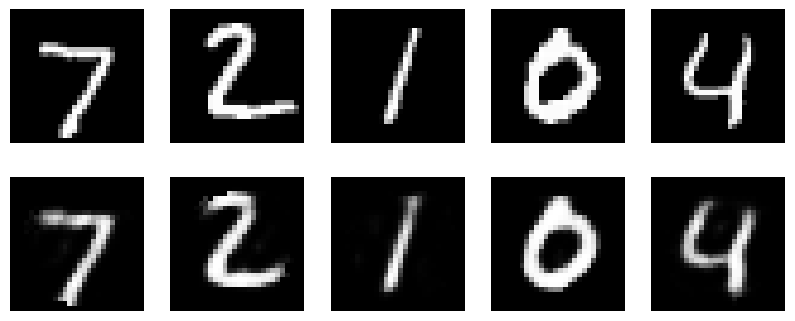

In [1]:
# Автоэнкодер на MNIST
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

# Загрузка и нормализация данных
(x_train, _), (x_test, _) = tf.keras.datasets.mnist.load_data()
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Форма входа
input_shape = (28, 28, 1)
x_train = x_train[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]

# Построение автоэнкодера
latent_dim = 64

# Энкодер
encoder = models.Sequential([
    layers.Flatten(input_shape=(28, 28, 1)),
    layers.Dense(128, activation='relu'),
    layers.Dense(latent_dim, activation='relu')
])

# Декодер
decoder = models.Sequential([
    layers.Dense(128, activation='relu', input_shape=(latent_dim,)),
    layers.Dense(28 * 28, activation='sigmoid'),
    layers.Reshape((28, 28, 1))
])

# Полная модель
autoencoder = models.Sequential([encoder, decoder])
autoencoder.compile(optimizer='adam', loss='mse')

# Обучение
autoencoder.fit(x_train, x_train,
                epochs=5,
                batch_size=256,
                validation_data=(x_test, x_test))

# Визуализация
n = 5
decoded_imgs = autoencoder.predict(x_test[:n])

plt.figure(figsize=(10, 4))
for i in range(n):
    # Оригинал
    plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28), cmap='gray')
    plt.axis('off')
    # Восстановленное
    plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28), cmap='gray')
    plt.axis('off')
plt.show()

#Transformer example

In [2]:
# Упрощённый трансформер-энкодер для текстовой классификации
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np

# Создадим синтетические данные
vocab_size = 1000
maxlen = 20
num_samples = 1000
embedding_dim = 32
num_heads = 2
ff_dim = 64

# Случайные последовательности слов (токенов)
x_train = np.random.randint(1, vocab_size, size=(num_samples, maxlen))
y_train = np.random.randint(0, 2, size=(num_samples, 1))  # бинарная классификация

# Вспомогательный слой: позиционные эмбеддинги
class PositionalEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super().__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

# Блок трансформера (Encoder-only)
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = models.Sequential([
            layers.Dense(ff_dim, activation="relu"),
            layers.Dense(embed_dim),
        ])
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training=False):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

# Сборка модели
inputs = layers.Input(shape=(maxlen,))
embedding_layer = PositionalEmbedding(maxlen, vocab_size, embedding_dim)
x = embedding_layer(inputs)
transformer_block = TransformerBlock(embedding_dim, num_heads, ff_dim)
x = transformer_block(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model = models.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

# Обучение
model.fit(x_train, y_train, batch_size=32, epochs=3, validation_split=0.2)

Epoch 1/3
25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - accuracy: 0.4961 - loss: 0.7215 - val_accuracy: 0.4400 - val_loss: 0.7297
Epoch 2/3
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6796 - loss: 0.6348 - val_accuracy: 0.4850 - val_loss: 0.7223
Epoch 3/3
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8312 - loss: 0.5226 - val_accuracy: 0.5050 - val_loss: 0.8165


# Transformer + attention

In [3]:
# Установка (не обязательна в Colab, но на всякий случай)
# !pip install -q tensorflow

import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np

# ----------------------------
# 1. Гиперпараметры
# ----------------------------
vocab_size = 10000    # Размер словаря
maxlen = 200          # Макс. длина последовательности
embedding_dim = 64    # Размерность эмбеддингов
num_heads = 4         # Число "голов" внимания
ff_dim = 128          # Размерность скрытого слоя в FFN
batch_size = 32
epochs = 2

# ----------------------------
# 2. Загрузка данных IMDB
# ----------------------------
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.imdb.load_data(num_words=vocab_size)

# Обрезаем/дополняем до maxlen
x_train = tf.keras.preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = tf.keras.preprocessing.sequence.pad_sequences(x_test, maxlen=maxlen)

# ----------------------------
# 3. Позиционные эмбеддинги
# ----------------------------
class PositionalEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super().__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen_actual = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen_actual, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

# ----------------------------
# 4. Блок трансформера (Encoder)
# ----------------------------
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        # <<< МЕХАНИЗМ ВНИМАНИЯ ЗДЕСЬ >>>
        self.att = layers.MultiHeadAttention(
            num_heads=num_heads,
            key_dim=embed_dim
        )
        self.ffn = models.Sequential([
            layers.Dense(ff_dim, activation="relu"),
            layers.Dense(embed_dim),
        ])
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training=False):
        # Self-attention
        attn_output = self.att(inputs, inputs)  # Q=K=V=inputs
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)

        # Feed-forward
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

# ----------------------------
# 5. Сборка модели
# ----------------------------
inputs = layers.Input(shape=(maxlen,))
embedding_layer = PositionalEmbedding(maxlen, vocab_size, embedding_dim)
x = embedding_layer(inputs)

# Один блок трансформера
transformer_block = TransformerBlock(embedding_dim, num_heads, ff_dim)
x = transformer_block(x)

# Агрегация и классификация
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model = models.Model(inputs=inputs, outputs=outputs)

# ----------------------------
# 6. Компиляция и обучение
# ----------------------------
model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

print(model.summary())

model.fit(
    x_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_test, y_test),
    verbose=1
)

17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ positional_embedding_1          │ (None, 200, 64)        │       652,800 │
│ (PositionalEmbedding)           │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_1             │ (None, 200, 64)        │        83,200 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_1      │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 736,065 (2.81 MB)

 Trainable params: 736,065 (2.81 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/2
782/782 ━━━━━━━━━━━━━━━━━━━━ 415s 525ms/step - accuracy: 0.7600 - loss: 0.4700 - val_accuracy: 0.8760 - val_loss: 0.2886
Epoch 2/2
782/782 ━━━━━━━━━━━━━━━━━━━━ 445s 569ms/step - accuracy: 0.9251 - loss: 0.1990 - val_accuracy: 0.8725 - val_loss: 0.3022


# Transformer - attention more clearly


1. **`scaled_dot_product_attention`** — реализует формулу:  
   \[
   \text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V
   \]

2. **`MultiHeadAttention`**:
   - Проецирует вход в `Q`, `K`, `V` через отдельные `Dense`-слои.
   - Делит каждый на `num_heads` частей.
   - Вычисляет внимание **независимо** для каждой головы.
   - Конкатенирует результаты и проецирует обратно.

3. Это **точно то же самое**, что делает `tf.keras.layers.MultiHeadAttention`, но теперь ты видишь **все шаги**.


In [4]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np

# ----------------------------
# Гиперпараметры
# ----------------------------
vocab_size = 10000
maxlen = 200
embedding_dim = 64
num_heads = 4
head_dim = embedding_dim // num_heads  # важно: embedding_dim % num_heads == 0
ff_dim = 128
batch_size = 32
epochs = 2

# ----------------------------
# Загрузка данных
# ----------------------------
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.imdb.load_data(num_words=vocab_size)
x_train = tf.keras.preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = tf.keras.preprocessing.sequence.pad_sequences(x_test, maxlen=maxlen)

# ----------------------------
# Позиционные эмбеддинги
# ----------------------------
class PositionalEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super().__init__()
        self.token_emb = layers.Embedding(vocab_size, embed_dim)
        self.pos_emb = layers.Embedding(maxlen, embed_dim)

    def call(self, x):
        maxlen_actual = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen_actual, delta=1)
        return self.token_emb(x) + self.pos_emb(positions)

# ----------------------------
# 1. Scaled Dot-Product Attention (вручную)
# ----------------------------
def scaled_dot_product_attention(Q, K, V, mask=None):
    """
    Q, K, V: тензоры формы (batch, seq_len, d_k)
    Возвращает: weighted sum of V, форма (batch, seq_len, d_k)
    """
    # Q·K^T / sqrt(d_k)
    matmul_qk = tf.matmul(Q, K, transpose_b=True)  # (batch, seq, seq)
    dk = tf.cast(tf.shape(K)[-1], tf.float32)
    scaled_logits = matmul_qk / tf.math.sqrt(dk)

    if mask is not None:
        scaled_logits += (mask * -1e9)

    attention_weights = tf.nn.softmax(scaled_logits, axis=-1)  # (batch, seq, seq)
    output = tf.matmul(attention_weights, V)  # (batch, seq, d_k)
    return output, attention_weights

# ----------------------------
# 2. Multi-Head Attention (вручную)
# ----------------------------
class MultiHeadAttention(layers.Layer):
    def __init__(self, embed_dim, num_heads):
        super().__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads

        assert embed_dim % num_heads == 0, "embed_dim must be divisible by num_heads"

        # Линейные проекции для Q, K, V (одна матрица на все головы)
        self.Wq = layers.Dense(embed_dim)
        self.Wk = layers.Dense(embed_dim)
        self.Wv = layers.Dense(embed_dim)
        self.Wo = layers.Dense(embed_dim)  # финальная проекция

    def split_heads(self, x, batch_size):
        """Разбиваем последнее измерение на (num_heads, head_dim) и транспонируем"""
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.head_dim))
        return tf.transpose(x, perm=[0, 2, 1, 3])  # (batch, num_heads, seq_len, head_dim)

    def call(self, q, k, v, mask=None):
        batch_size = tf.shape(q)[0]

        # Линейные преобразования
        Q = self.Wq(q)  # (batch, seq, embed_dim)
        K = self.Wk(k)
        V = self.Wv(v)

        # Разбиваем на головы
        Q = self.split_heads(Q, batch_size)  # (batch, num_heads, seq, head_dim)
        K = self.split_heads(K, batch_size)
        V = self.split_heads(V, batch_size)

        # Считаем внимание по каждой голове
        scaled_attention, _ = scaled_dot_product_attention(Q, K, V, mask)
        # scaled_attention: (batch, num_heads, seq_len, head_dim)

        # Объединяем головы обратно
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch, seq, num_heads, head_dim)
        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.embed_dim))  # (batch, seq, embed_dim)

        # Финальная линейная проекция
        output = self.Wo(concat_attention)
        return output

# ----------------------------
# 3. Блок трансформера (Encoder)
# ----------------------------
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        self.mha = MultiHeadAttention(embed_dim, num_heads)  # <<< наша ручная реализация!
        self.ffn = models.Sequential([
            layers.Dense(ff_dim, activation='relu'),
            layers.Dense(embed_dim)
        ])
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, x, training=False):
        attn_output = self.mha(x, x, x)  # Self-attention: Q=K=V=x
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)

        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

# ----------------------------
# 4. Сборка модели
# ----------------------------
inputs = layers.Input(shape=(maxlen,))
x = PositionalEmbedding(maxlen, vocab_size, embedding_dim)(inputs)
x = TransformerBlock(embedding_dim, num_heads, ff_dim)(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

model = models.Model(inputs=inputs, outputs=outputs)

# ----------------------------
# 5. Обучение
# ----------------------------
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
print(model.summary())

model.fit(
    x_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_test, y_test),
    verbose=1
)

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ positional_embedding_2          │ (None, 200, 64)        │       652,800 │
│ (PositionalEmbedding)           │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_2             │ (None, 200, 64)        │        33,472 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_2      │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 686,337 (2.62 MB)

 Trainable params: 686,337 (2.62 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/2
782/782 ━━━━━━━━━━━━━━━━━━━━ 225s 282ms/step - accuracy: 0.7512 - loss: 0.4772 - val_accuracy: 0.8790 - val_loss: 0.2882
Epoch 2/2
782/782 ━━━━━━━━━━━━━━━━━━━━ 222s 283ms/step - accuracy: 0.9186 - loss: 0.2047 - val_accuracy: 0.8634 - val_loss: 0.3297


# Visualise attention

Чтобы увидеть внимание конкретного слова, найди его позицию по оси Y и посмотри, на какие слова по X оно "смотрит".
Можно визуализировать несколько голов — просто замени [:, 0, :, :] на другие индексы.
Для длинных текстов лучше обрезать до первых 50–100 слов.

1641221/1641221 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Обучаем модель...
Epoch 1/2
782/782 ━━━━━━━━━━━━━━━━━━━━ 142s 175ms/step - accuracy: 0.7440 - loss: 0.4858
Epoch 2/2
782/782 ━━━━━━━━━━━━━━━━━━━━ 135s 173ms/step - accuracy: 0.9237 - loss: 0.2011


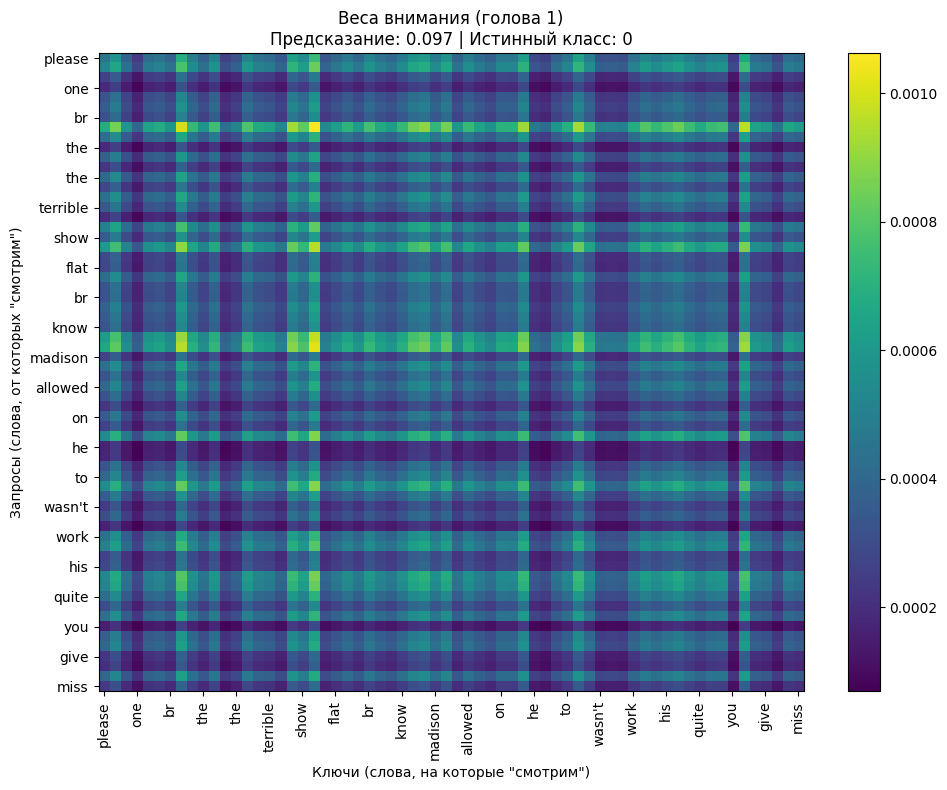


Текст отзыва:
please give this one a miss br br and the rest of the cast rendered terrible performances the show is flat flat flat br br i don't know how michael madison could have allowed this one on his plate he almost seemed to know this wasn't going to work out and his performance was quite so all you madison fans give this a miss


In [5]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt

# ----------------------------
# Гиперпараметры (оставим как раньше)
# ----------------------------
vocab_size = 10000
maxlen = 200
embedding_dim = 64
num_heads = 4
head_dim = embedding_dim // num_heads
ff_dim = 128
batch_size = 32
epochs = 2

# ----------------------------
# Загрузка данных
# ----------------------------
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.imdb.load_data(num_words=vocab_size)
x_train = tf.keras.preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = tf.keras.preprocessing.sequence.pad_sequences(x_test, maxlen=maxlen)

# Получим обратное отображение слов (для печати текста)
word_index = tf.keras.datasets.imdb.get_word_index()
reverse_word_index = {v: k for k, v in word_index.items()}

def decode_review(text):
    return ' '.join([reverse_word_index.get(i - 3, '?') for i in text if i > 3])

# ----------------------------
# Позиционные эмбеддинги
# ----------------------------
class PositionalEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super().__init__()
        self.token_emb = layers.Embedding(vocab_size, embed_dim)
        self.pos_emb = layers.Embedding(maxlen, embed_dim)

    def call(self, x):
        maxlen_actual = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen_actual, delta=1)
        return self.token_emb(x) + self.pos_emb(positions)

# ----------------------------
# 1. Scaled Dot-Product Attention (возвращает веса!)
# ----------------------------
def scaled_dot_product_attention(Q, K, V, mask=None):
    matmul_qk = tf.matmul(Q, K, transpose_b=True)
    dk = tf.cast(tf.shape(K)[-1], tf.float32)
    scaled_logits = matmul_qk / tf.math.sqrt(dk)

    if mask is not None:
        scaled_logits += (mask * -1e9)

    attention_weights = tf.nn.softmax(scaled_logits, axis=-1)
    output = tf.matmul(attention_weights, V)
    return output, attention_weights  # <<< возвращаем веса

# ----------------------------
# 2. Multi-Head Attention с опцией возврата весов
# ----------------------------
class MultiHeadAttention(layers.Layer):
    def __init__(self, embed_dim, num_heads):
        super().__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        assert embed_dim % num_heads == 0

        self.Wq = layers.Dense(embed_dim)
        self.Wk = layers.Dense(embed_dim)
        self.Wv = layers.Dense(embed_dim)
        self.Wo = layers.Dense(embed_dim)

    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.head_dim))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, q, k, v, return_attention_weights=False):
        batch_size = tf.shape(q)[0]

        Q = self.Wq(q)
        K = self.Wk(k)
        V = self.Wv(v)

        Q = self.split_heads(Q, batch_size)
        K = self.split_heads(K, batch_size)
        V = self.split_heads(V, batch_size)

        scaled_attention, attention_weights = scaled_dot_product_attention(Q, K, V)
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])
        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.embed_dim))
        output = self.Wo(concat_attention)

        if return_attention_weights:
            # Возвращаем среднее по головам или первую голову — выберем первую
            # attention_weights: (batch, num_heads, seq_len, seq_len)
            return output, attention_weights[:, 0, :, :]  # первая голова
        return output

# ----------------------------
# 3. Transformer Block (сохраняем ссылку на MHA для доступа к весам)
# ----------------------------
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        self.mha = MultiHeadAttention(embed_dim, num_heads)
        self.ffn = models.Sequential([
            layers.Dense(ff_dim, activation='relu'),
            layers.Dense(embed_dim)
        ])
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, x, training=False, return_attention_weights=False):
        if return_attention_weights:
            attn_output, attn_weights = self.mha(x, x, x, return_attention_weights=True)
        else:
            attn_output = self.mha(x, x, x)
            attn_weights = None

        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        output = self.layernorm2(out1 + ffn_output)

        if return_attention_weights:
            return output, attn_weights
        return output

# ----------------------------
# 4. Модель с возможностью получения весов внимания
# ----------------------------
class TransformerWithAttention(models.Model):
    def __init__(self, maxlen, vocab_size, embed_dim, num_heads, ff_dim):
        super().__init__()
        self.embedding = PositionalEmbedding(maxlen, vocab_size, embed_dim)
        self.transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
        self.global_pool = layers.GlobalAveragePooling1D()
        self.dropout = layers.Dropout(0.1)
        self.classifier = layers.Dense(1, activation='sigmoid')

    def call(self, inputs, training=False, return_attention_weights=False):
        x = self.embedding(inputs)
        if return_attention_weights:
            x, attn_weights = self.transformer_block(x, training=training, return_attention_weights=True)
        else:
            x = self.transformer_block(x, training=training)
            attn_weights = None
        x = self.global_pool(x)
        x = self.dropout(x, training=training)
        logits = self.classifier(x)
        if return_attention_weights:
            return logits, attn_weights
        return logits

# ----------------------------
# 5. Создание и обучение модели
# ----------------------------
model = TransformerWithAttention(maxlen, vocab_size, embedding_dim, num_heads, ff_dim)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

print("Обучаем модель...")
model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1)

# ----------------------------
# 6. Визуализация внимания
# ----------------------------
# Выберем один пример из теста
sample_idx = 0
input_seq = x_test[sample_idx:sample_idx+1]  # форма (1, maxlen)
true_label = y_test[sample_idx]

# Получаем предсказание и веса внимания
pred, attn_weights = model(input_seq, return_attention_weights=True)
pred = float(pred[0, 0])
attn_weights = attn_weights[0].numpy()  # (seq_len, seq_len)

# Декодируем текст
decoded = decode_review(x_test[sample_idx])
words = [w for w in decoded.split() if w != '?']
actual_len = len(words)

# Обрежем матрицу внимания до реальной длины (без padding)
attn_trimmed = attn_weights[:actual_len, :actual_len]

# Визуализация
plt.figure(figsize=(10, 8))
plt.imshow(attn_trimmed, cmap='viridis', aspect='auto')
plt.colorbar()
plt.title(f'Веса внимания (голова 1)\nПредсказание: {pred:.3f} | Истинный класс: {true_label}', fontsize=12)
plt.xlabel('Ключи (слова, на которые "смотрим")')
plt.ylabel('Запросы (слова, от которых "смотрим")')

# Подписи осей — только каждое 3-е слово, чтобы не перегружать
step = max(1, len(words) // 20)
plt.xticks(range(0, actual_len, step), [words[i] for i in range(0, actual_len, step)], rotation=90)
plt.yticks(range(0, actual_len, step), [words[i] for i in range(0, actual_len, step)])

plt.tight_layout()
plt.show()

print("\nТекст отзыва:")
print(decoded[:500] + "..." if len(decoded) > 500 else decoded)

# Final examlpe

Загрузка данных IMDB...
Обучаем новую модель...
Epoch 1/2
782/782 ━━━━━━━━━━━━━━━━━━━━ 190s 237ms/step - accuracy: 0.7417 - loss: 0.4914 - val_accuracy: 0.8640 - val_loss: 0.3149
Epoch 2/2
782/782 ━━━━━━━━━━━━━━━━━━━━ 201s 237ms/step - accuracy: 0.9204 - loss: 0.2058 - val_accuracy: 0.8738 - val_loss: 0.2997

Визуализация внимания для примера из тестового набора


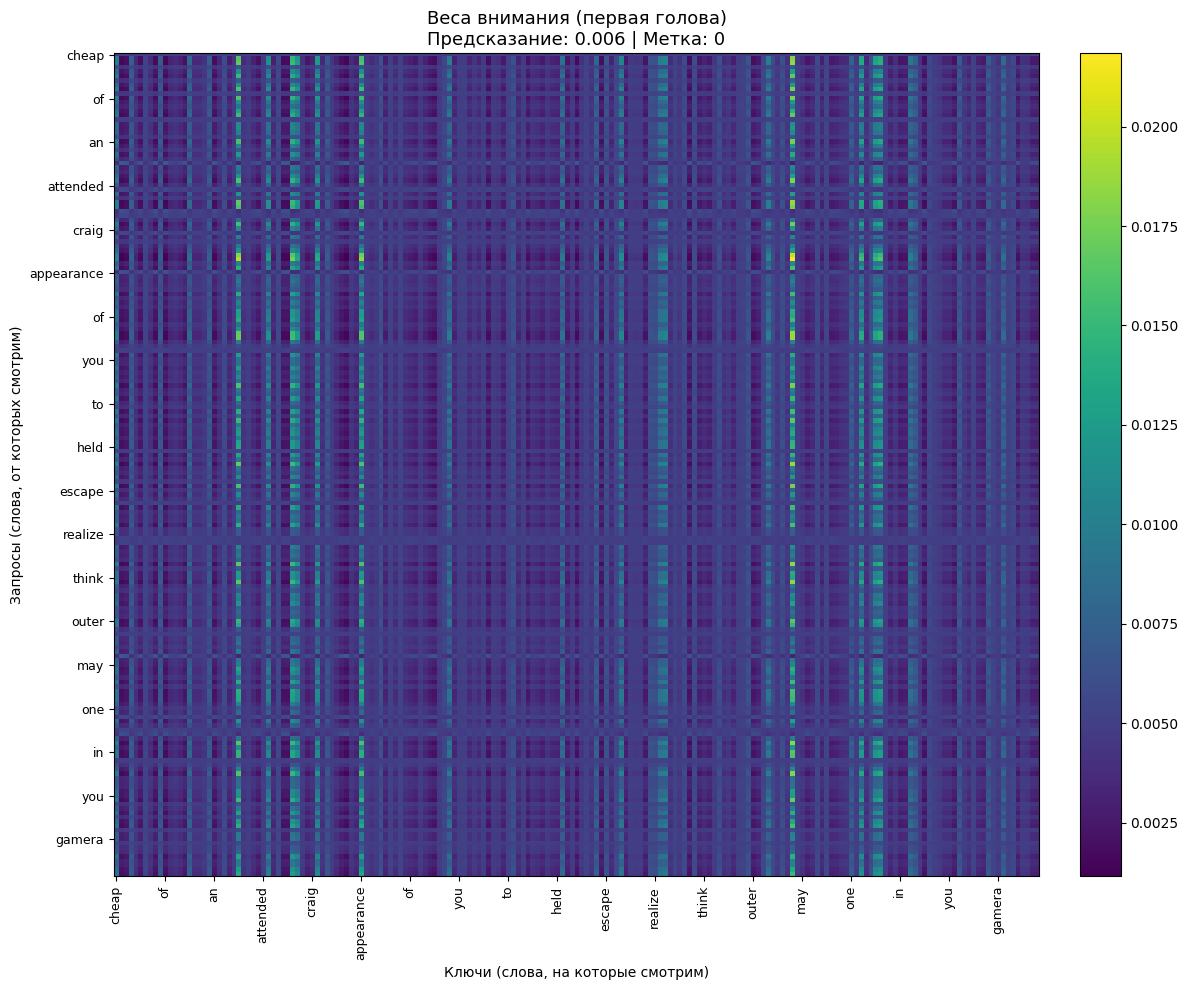


Текст отзыва:
cheap to capitalize on the success of 1 star attack of the monsters was for me at the time 1975 an almost painful viewing experience br br last weekend i attended the godzilla fest known as g fest where carl craig one of the stars of gamera vs made an appearance of course they featured this movie it was one of the most hilarious bad movies ever made of course you have to be in the right frame of mind to watch it in one scene for example the boy held prisoner on board the alien space craft manage...


In [7]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt
import os

# ----------------------------
# Гиперпараметры (должны совпадать с обучением)
# ----------------------------
vocab_size = 10000
maxlen = 200
embedding_dim = 64
num_heads = 4
head_dim = embedding_dim // num_heads
ff_dim = 128
batch_size = 32
epochs = 2
model_path = "/content/transformer_imdb"

# ----------------------------
# Вспомогательные функции
# ----------------------------
def decode_review(encoded_review):
    word_index = tf.keras.datasets.imdb.get_word_index()
    reverse_word_index = {v: k for k, v in word_index.items()}
    return ' '.join([reverse_word_index.get(i - 3, '?') for i in encoded_review if i > 3])

# ----------------------------
# Загрузка данных
# ----------------------------
print("Загрузка данных IMDB...")
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.imdb.load_data(num_words=vocab_size)
x_train = tf.keras.preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = tf.keras.preprocessing.sequence.pad_sequences(x_test, maxlen=maxlen)

# ----------------------------
# Определение слоёв (как в твоём коде)
# ----------------------------
class PositionalEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super().__init__()
        self.token_emb = layers.Embedding(vocab_size, embed_dim)
        self.pos_emb = layers.Embedding(maxlen, embed_dim)
    def call(self, x):
        maxlen_actual = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen_actual, delta=1)
        return self.token_emb(x) + self.pos_emb(positions)

def scaled_dot_product_attention(Q, K, V, mask=None):
    matmul_qk = tf.matmul(Q, K, transpose_b=True)
    dk = tf.cast(tf.shape(K)[-1], tf.float32)
    scaled_logits = matmul_qk / tf.math.sqrt(dk)
    if mask is not None:
        scaled_logits += (mask * -1e9)
    attention_weights = tf.nn.softmax(scaled_logits, axis=-1)
    output = tf.matmul(attention_weights, V)
    return output, attention_weights

class MultiHeadAttention(layers.Layer):
    def __init__(self, embed_dim, num_heads):
        super().__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        assert embed_dim % num_heads == 0
        self.Wq = layers.Dense(embed_dim)
        self.Wk = layers.Dense(embed_dim)
        self.Wv = layers.Dense(embed_dim)
        self.Wo = layers.Dense(embed_dim)

    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.head_dim))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, q, k, v, mask=None, return_weights=False):
        batch_size = tf.shape(q)[0]
        Q = self.Wq(q)
        K = self.Wk(k)
        V = self.Wv(v)
        Q = self.split_heads(Q, batch_size)
        K = self.split_heads(K, batch_size)
        V = self.split_heads(V, batch_size)
        scaled_attention, attn_weights = scaled_dot_product_attention(Q, K, V, mask)
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])
        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.embed_dim))
        output = self.Wo(concat_attention)
        if return_weights:
            return output, attn_weights[:, 0, :, :]  # первая голова
        return output

class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        self.mha = MultiHeadAttention(embed_dim, num_heads)
        self.ffn = models.Sequential([
            layers.Dense(ff_dim, activation='relu'),
            layers.Dense(embed_dim)
        ])
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, x, training=False, return_weights=False):
        if return_weights:
            attn_output, weights = self.mha(x, x, x, return_weights=True)
        else:
            attn_output = self.mha(x, x, x)
            weights = None
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        output = self.layernorm2(out1 + ffn_output)
        if return_weights:
            return output, weights
        return output

# ----------------------------
# Создание модели с поддержкой возврата весов
# ----------------------------
class TransformerForAttention(models.Model):
    def __init__(self, maxlen, vocab_size, embed_dim, num_heads, ff_dim):
        super().__init__()
        self.embedding = PositionalEmbedding(maxlen, vocab_size, embed_dim)
        self.transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
        self.global_pool = layers.GlobalAveragePooling1D()
        self.dropout = layers.Dropout(0.1)
        self.classifier = layers.Dense(1, activation='sigmoid')

    def call(self, inputs, training=False, return_weights=False):
        x = self.embedding(inputs)
        if return_weights:
            x, weights = self.transformer_block(x, training=training, return_weights=True)
        else:
            x = self.transformer_block(x, training=training)
            weights = None
        x = self.global_pool(x)
        x = self.dropout(x, training=training)
        out = self.classifier(x)
        if return_weights:
            return out, weights
        return out

# ----------------------------
# Обучение или загрузка модели
# ----------------------------
if os.path.exists(model_path):
    print("Загружаем сохранённую модель...")
    model = tf.keras.models.load_model(model_path, custom_objects={
        'PositionalEmbedding': PositionalEmbedding,
        'MultiHeadAttention': MultiHeadAttention,
        'TransformerBlock': TransformerBlock,
        'TransformerForAttention': TransformerForAttention
    })
else:
    print("Обучаем новую модель...")
    model = TransformerForAttention(maxlen, vocab_size, embedding_dim, num_heads, ff_dim)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.fit(
        x_train, y_train,
        batch_size=batch_size,
        epochs=epochs,
        validation_data=(x_test, y_test),
        verbose=1
    )
    #print("Сохраняем модель...")
    #model.save(model_path, save_format='tf')

# ----------------------------
# Функция визуализации внимания
# ----------------------------
def predict_and_visualize_attention(sample_idx=0):
    input_seq = x_test[sample_idx:sample_idx+1]  # (1, maxlen)
    true_label = y_test[sample_idx]

    pred, attn_weights = model(input_seq, return_weights=True)
    pred_score = float(pred[0, 0])
    attn = attn_weights[0].numpy()  # (seq_len, seq_len)

    # Декодируем текст
    decoded = decode_review(x_test[sample_idx])
    words = [w for w in decoded.split() if w != '?']
    actual_len = len(words)

    if actual_len == 0:
        print("Пустой отзыв!")
        return

    # Обрезаем матрицу внимания до реальной длины
    attn_trimmed = attn[:actual_len, :actual_len]

    # Визуализация
    plt.figure(figsize=(12, 10))
    im = plt.imshow(attn_trimmed, cmap='viridis', aspect='auto')
    plt.colorbar(im, fraction=0.046, pad=0.04)
    plt.title(f'Веса внимания (первая голова)\nПредсказание: {pred_score:.3f} | Метка: {true_label}', fontsize=13)
    plt.xlabel('Ключи (слова, на которые смотрим)')
    plt.ylabel('Запросы (слова, от которых смотрим)')

    # Подписи: не более 20 слов на ось
    step = max(1, (actual_len + 19) // 20)
    plt.xticks(range(0, actual_len, step), [words[i] for i in range(0, actual_len, step)], rotation=90, fontsize=9)
    plt.yticks(range(0, actual_len, step), [words[i] for i in range(0, actual_len, step)], fontsize=9)

    plt.tight_layout()
    plt.show()

    print("\nТекст отзыва:")
    print((decoded[:500] + "...") if len(decoded) > 500 else decoded)

# ----------------------------
# Запуск визуализации
# ----------------------------
print("\n" + "="*50)
print("Визуализация внимания для примера из тестового набора")
print("="*50)
predict_and_visualize_attention(sample_idx=42)  # попробуй разные индексы: 0, 10, 42, 100...